In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import time

import sys
sys.path.append('..')
from src.utils.plotting import plot_roc

from joblib import dump, load
import pickle
import os
from tqdm import tqdm

In [2]:
import featuretools as ft

In [3]:
import xgboost as xgb

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, roc_curve, auc

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

In [5]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

In [6]:
pd.options.mode.use_inf_as_na = True

In [7]:
data_folder = '/media/siri/78C6823EC681FD1E/minio/data/kaggle/ncaa/'

### Read Feature Matrices and combine into one

In [8]:
fm_paths = [data_folder + p for p in os.listdir(data_folder) if '_fm' in p]
fms = [pd.read_parquet(path) for path in fm_paths]
fm = pd.concat(fms, axis=0)
fm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 639200 entries, 2184_1228 to 692_1417
Columns: 974 entries, GameID to LTeams.TREND(WTeam_events.LPoints, Date)
dtypes: float64(954), int64(18), object(2)
memory usage: 4.6+ GB


In [9]:
fm.head()

,GameID,WScore,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,...,LTeams.MEDIAN(WTeam_events.LPoints),LTeams.MEDIAN(WTeam_events.ElapsedSeconds),LTeams.AVG_TIME_BETWEEN(WTeam_events.Date),LTeams.TIME_SINCE_LAST(WTeam_events.Date),LTeams.SKEW(WTeam_events.WPoints),LTeams.SKEW(WTeam_events.LPoints),LTeams.SKEW(WTeam_events.ElapsedSeconds),"LTeams.TREND(WTeam_events.ElapsedSeconds, Date)","LTeams.TREND(WTeam_events.WPoints, Date)","LTeams.TREND(WTeam_events.LPoints, Date)"
Game_WTeamID,,,,,,,,,,,,,,,,,,,,,
2184_1228,2184,81.0,64.0,N,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2184_1328,2184,81.0,64.0,N,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2185_1106,2185,77.0,70.0,H,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2185_1354,2185,77.0,70.0,H,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2186_1112,2186,63.0,56.0,H,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
fm.index.is_unique

False

In [11]:
#cond = fm.isna().all(axis=0)
#cond = cond.where(cond == False).dropna()
#fm = fm.filter(items=cond.index, axis=1)

In [12]:
#fm.info()

In [13]:
#fm.loc[fm.isna().any(axis=1)]
#fm_hm = fm[fm.columns.difference(['WScore', 'LScore', 'WLoc', 'NumOT', 'Season', 'WTeamID', 'LTeamID', 'TourneyName'])]

In [14]:
#fm = fm.interpolate('linear', axis=0, limit_direction='both')

In [15]:
#fm.loc[fm.isna().any(axis=1)]

In [16]:
from featuretools import selection

In [17]:
fm = selection.remove_low_information_features(fm)
fm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 639200 entries, 2184_1228 to 692_1417
Columns: 959 entries, GameID to LTeams.TREND(WTeam_events.LPoints, Date)
dtypes: float64(940), int64(17), object(2)
memory usage: 4.6+ GB


#### set game outcome (value to be predicted), convert TourneyName to categorical and drop columns that are not needed as features

In [18]:
#def set_game_outcome(row):
#    if row['WTeamID'] < row['LTeamID']:
#        row['Outcome'] = 1
#    return row

In [19]:
def convert_to_categorical(series):
    values = series.unique()
    cat_map = {cat_val:cat_num  for cat_num, cat_val in enumerate(values)}    
    return series.map(cat_map), cat_map 

In [20]:
#fm['Outcome'] = 0
#fm = fm.apply(set_game_outcome, axis=1)
fm['TourneyName'], tourney_cat_map = convert_to_categorical(fm['TourneyName'])
fm['WLoc'], wloc_cat_map = convert_to_categorical(fm['WLoc'])
test_cond = (fm.Season > 2013) & (fm.TourneyName == tourney_cat_map['NCAA'])
fm = fm.drop(columns=['Season','WTeamID','LTeamID'])
fm.head()

,GameID,WScore,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,...,LTeams.MEDIAN(WTeam_events.LPoints),LTeams.MEDIAN(WTeam_events.ElapsedSeconds),LTeams.AVG_TIME_BETWEEN(WTeam_events.Date),LTeams.TIME_SINCE_LAST(WTeam_events.Date),LTeams.SKEW(WTeam_events.WPoints),LTeams.SKEW(WTeam_events.LPoints),LTeams.SKEW(WTeam_events.ElapsedSeconds),"LTeams.TREND(WTeam_events.ElapsedSeconds, Date)","LTeams.TREND(WTeam_events.WPoints, Date)","LTeams.TREND(WTeam_events.LPoints, Date)"
Game_WTeamID,,,,,,,,,,,,,,,,,,,,,
2184_1228,2184,81.0,64.0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2184_1328,2184,81.0,64.0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2185_1106,2185,77.0,70.0,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2185_1354,2185,77.0,70.0,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2186_1112,2186,63.0,56.0,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
X_test = fm.loc[test_cond]
X_train = fm.loc[~test_cond]
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1300 entries, 1916_1214 to 1915_1246
Columns: 956 entries, GameID to LTeams.TREND(WTeam_events.LPoints, Date)
dtypes: float64(940), int64(16)
memory usage: 9.5+ MB


In [22]:
y_train = X_train['Outcome']
y_test = X_test['Outcome']
X_train = X_train.drop(columns=['Outcome'])
X_test = X_test.drop(columns=['Outcome'])
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 637900 entries, 2184_1228 to 692_1417
Columns: 955 entries, GameID to LTeams.TREND(WTeam_events.LPoints, Date)
dtypes: float64(940), int64(15)
memory usage: 4.5+ GB


In [23]:
del fm

#### Modeling

In [24]:
target_names = ['wins', 'losses']

In [26]:
params_xgb = {'n_estimators' : [1,2,4,8,16,32,64,128,256],
          'gamma' : np.linspace(0.01,1,10, endpoint=True),
          'learning_rate' : np.linspace(.01, 1, 10, endpoint=True),
          'reg_lambda' : np.linspace(.01, 10, 10, endpoint=True),
          'max_depth' : np.linspace(1, 32, 10, endpoint=True, dtype=int)
        }
start = time.time()
cv_xgb  = RandomizedSearchCV(xgb.XGBClassifier(objective='binary:logistic',random_state=42), param_distributions=params_xgb, 
                             random_state=42, cv=5, n_jobs=4)
cv_xgb.fit(X_train, y_train)
end = time.time()
print(end - start)

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGKILL(-9), SIGKILL(-9)}

In [ ]:
dump(cv_xgb, data_folder+'xgb_ramdomcv.joblib')

In [ ]:
cv_xgb = load(data_folder+'logr_ramdomcv.joblib')

In [18]:
clf_xgb_model = xgb.XGBClassifier(random_state=42,
                                  objective='binary:logistic',
                                  n_estimators=cv_xgb.best_params_['n_estimators'],
                                  gamma=cv_xgb.best_params_['gamma'],
                                  learning_rate=cv_xgb.best_params_['learning_rate'],
                                  reg_lambda=cv_xgb.best_params_['reg_lambda'],
                                  max_depth=cv_xgb.best_params_['max_depth'],
                                  n_jobs=3)
start = time.time()
clf_xgb_model.fit(X_train, y_train)
end = time.time()
print(end - start)

49.711326122283936


In [21]:
y_pred_xgb = clf_xgb_model.predict(X_test)
score_xgb = accuracy_score(y_test, y_pred_xgb)
rscore_xgb = recall_score(y_test, y_pred_xgb)
pscore_xgb = precision_score(y_test, y_pred_xgb)
print('Accuracy score for XGBoost ', score_xgb)
print('Recall score for XGBoost ', rscore_xgb)
print('Precision score for XGBoost ', pscore_xgb)
print(classification_report(y_test, y_pred_xgb, target_names=target_names))

Accuracy score for XGBoost  0.5634674922600619
Recall score for XGBoost  0.5031446540880503
Precision score for XGBoost  0.5633802816901409
              precision    recall  f1-score   support

        wins       0.56      0.62      0.59       164
      losses       0.56      0.50      0.53       159

   micro avg       0.56      0.56      0.56       323
   macro avg       0.56      0.56      0.56       323
weighted avg       0.56      0.56      0.56       323



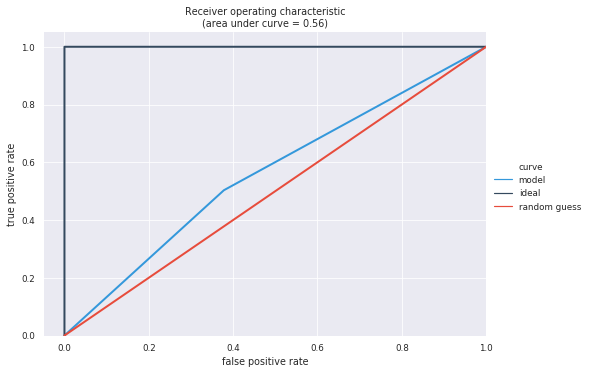

In [24]:
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, y_pred_xgb)
xgb_roc_auc = auc(xgb_fpr, xgb_tpr)

plot_roc(xgb_fpr, xgb_tpr, xgb_roc_auc)